In [1]:
%load_ext autoreload

%autoreload complete

# Duffing chain examples

In [2]:
import sys
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import sympy
from npad_cupy.duffing_chain_utils import (
    create_random_Duffing_Chain,
    duffing_chain_full_ham,
    duffing_chain_num_ham,
)
from npad_cupy.duffing_utils import create_system_NPAD
from tqdm.notebook import tqdm

rng = np.random.default_rng()

import matplotlib as mpl
from icecream import ic
from npad_cupy.gpu.npad import npad_diagonalize
from npad_cupy.symbolic import npad_eliminate_couplings

mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["font.size"] = 25
mpl.rcParams["lines.linewidth"] = 3
mpl.rcParams["lines.markersize"] = 8
mpl.rcParams["text.usetex"] = True
mpl.rcParams["legend.fontsize"] = 20
mpl.rcParams["axes.titlesize"] = 20

In [3]:
global_chain_size = 3
global_ntrunc = 3
system_dims = [global_ntrunc] * global_chain_size
example_chain = create_random_Duffing_Chain(
    chain_size=global_chain_size, ntrunc=global_ntrunc
)

In [4]:
chain_full_ham, sub_params = duffing_chain_full_ham(example_chain, return_subs=True)
two_ex_subspace = list(qt.state_number_enumerate(system_dims, excitations=2))
two_ex_idx = [qt.state_number_index(system_dims, state) for state in two_ex_subspace]
H2 = chain_full_ham[two_ex_idx, two_ex_idx]

In [5]:
H2

Matrix([
[0,      0,                 0,      0,               0,                 0,      0,               0,               0,                 0],
[0, omega3,                 0,      g,               0,                 0,      0,               0,               0,                 0],
[0,      0, alpha3 + 2*omega3,      0,       sqrt(2)*g,                 0,      0,               0,               0,                 0],
[0,      g,                 0, omega2,               0,                 0,      g,               0,               0,                 0],
[0,      0,         sqrt(2)*g,      0, omega2 + omega3,         sqrt(2)*g,      0,               g,               0,                 0],
[0,      0,                 0,      0,       sqrt(2)*g, alpha2 + 2*omega2,      0,               0,       sqrt(2)*g,                 0],
[0,      0,                 0,      g,               0,                 0, omega1,               0,               0,                 0],
[0,      0,                 0,  

We should remove $\omega_1$ from this dictionary, so that we can use it as a parameter to test

In [6]:
test_sub_params = {
    key: val
    for key, val in sub_params.items()
    if key != sympy.symbols("omega1", positive=True)
}
test_sub_params

{omega2: array(-0.31881297),
 omega3: array(0.45407004),
 alpha1: array(-0.30054546),
 alpha2: array(-0.30078021),
 alpha3: array(-0.30818799),
 g: 0.1}

In [7]:
qubit1_var_ham_2photon = sympy.lambdify(
    sympy.symbols("omega1", positive=True),
    H2.subs(test_sub_params),
)
qubit1_var_ham = sympy.lambdify(
    sympy.symbols("omega1", positive=True),
    chain_full_ham.subs(test_sub_params),
)

In [8]:
qt.Qobj(qubit1_var_ham_2photon(5)).eigenenergies()

array([-0.96045918, -0.33338706,  0.        ,  0.11143159,  0.4667639 ,
        0.64039116,  4.66807502,  5.00188023,  5.46863586,  9.70344018])

In [9]:
def npad_eigvals(H):
    return np.diagonal(npad_diagonalize(H))

In [10]:
npad_eigvals(qubit1_var_ham_2photon(5))

TypeError: Unsupported type <class 'numpy.ndarray'>

In [ ]:
np.sort(npad_eigvals(qubit1_var_ham_2photon(5)))

array([ 0.        +0.j,  4.96457724+0.j,  5.26786109+0.j,  5.60367019+0.j,
        9.67567922+0.j, 10.09177389+0.j, 10.36846475+0.j, 10.56189569+0.j,
       10.75955302+0.j, 11.01807516+0.j])

In [ ]:
w1list = np.linspace(3, 6, 500)
evals_2photon = np.asarray(
    [qt.Qobj(qubit1_var_ham_2photon(w)).eigenenergies()[1:] for w in tqdm(w1list)]
)
evals_full = np.asarray(
    [qt.Qobj(qubit1_var_ham(w)).eigenenergies()[1:] for w in tqdm(w1list)]
)
evals_2photon_npad = np.asarray(
    [npad_eigvals(qubit1_var_ham_2photon(w))[1:] for w in tqdm(w1list)]
)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

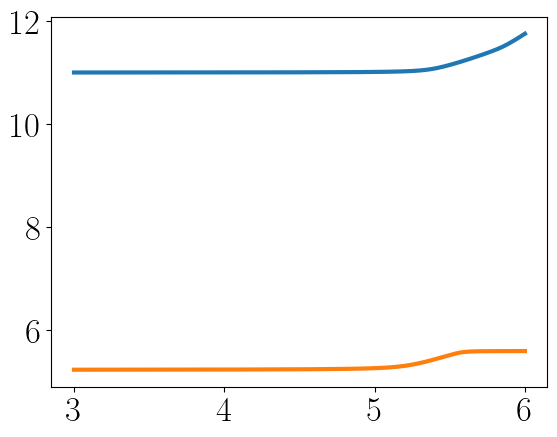

In [ ]:
plt.plot(w1list, np.real(evals_2photon_npad[:, 1:3]))

[(3.0, 6.0),
 Text(0.5, 0, 'Tunable qubit frequency (GHz)'),
 Text(0.5, 1.0, 'Full Hamiltonian')]

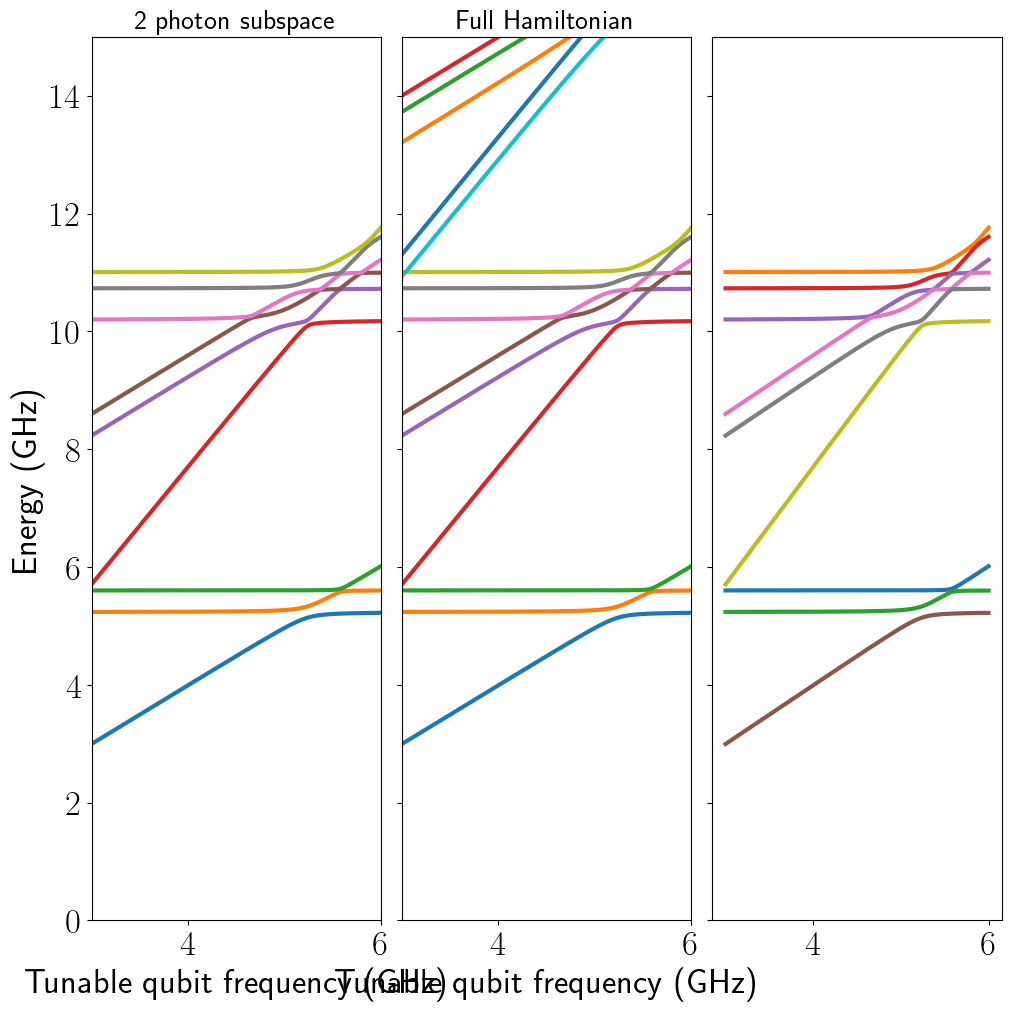

In [ ]:
fig, ax = plt.subplots(
    1,
    3,
    layout="constrained",
    sharey=True,
    figsize=(10, 10),
)
ax[0].plot(w1list, np.real(evals_2photon))
ax[1].plot(w1list, np.real(evals_full))
ax[2].plot(w1list, np.real(evals_2photon_npad))
ax[0].set(
    xlim=(3, 6),
    xlabel="Tunable qubit frequency (GHz)",
    ylabel="Energy (GHz)",
    ylim=(0, 15),
    title="2 photon subspace",
)
ax[1].set(
    xlim=(3, 6),
    xlabel="Tunable qubit frequency (GHz)",
    title="Full Hamiltonian",
)

# Large scale NPAD example for benchmarking

We want to block diagonalize a chain of duffing oscillators into a chain of qubits.

In [ ]:
chain_full_ham, sub_params = duffing_chain_full_ham(example_chain, return_subs=True)

There are 3^5 = 243 levels in this chain of size 5. We want to turn this into a 2^5=32 level 5 qubit chain. First we need to partition levels we care about and those we don't.

In [ ]:
all_levels = list(qt.state_number_enumerate(system_dims))
qubit_chain_levels = [label for label in all_levels if max(label) <= 1]
other_levels = [label for label in all_levels if label not in qubit_chain_levels]

Now that we have identified labels for each set of levels, we need to find their indices in the matrix (so that we can either reorganize it, or just find the list of couplings).

In [ ]:
chain_idx = [qt.state_number_index(system_dims, label) for label in qubit_chain_levels]
other_idx = [qt.state_number_index(system_dims, label) for label in other_levels]

Now, we can find the couping matrix. This will not be square.

In [ ]:
coupling_offdiags = chain_full_ham[chain_idx, other_idx]
coupling_offdiags.print_nonzero()

[                   ]
[                   ]
[                   ]
[X X                ]
[                   ]
[                   ]
[  X       X        ]
[   X X X   X       ]


Unfortunately, SymPy doesn't have a nice functions to find nonzero indices, so we have to loop through all elements. This could be parallelized later.

In [ ]:
undesired_couplings = [
    (i, j) for i, j in product(chain_idx, other_idx) if chain_full_ham[i, j].is_nonzero
]
undesired_couplings

[(4, 2), (4, 6), (12, 6), (12, 18), (13, 7), (13, 11), (13, 15), (13, 19)]

In [ ]:
undesired_coupling_labels = [
    (qt.state_index_number(system_dims, i), qt.state_index_number(system_dims, j))
    for (i, j) in undesired_couplings
]
undesired_coupling_labels

[((0, 1, 1), (0, 0, 2)),
 ((0, 1, 1), (0, 2, 0)),
 ((1, 1, 0), (0, 2, 0)),
 ((1, 1, 0), (2, 0, 0)),
 ((1, 1, 1), (0, 2, 1)),
 ((1, 1, 1), (1, 0, 2)),
 ((1, 1, 1), (1, 2, 0)),
 ((1, 1, 1), (2, 0, 1))]

In [ ]:
np.diff(np.asarray(undesired_coupling_labels), axis=1)

array([[[ 0, -1,  1]],

       [[ 0,  1, -1]],

       [[-1,  1,  0]],

       [[ 1, -1,  0]],

       [[-1,  1,  0]],

       [[ 0, -1,  1]],

       [[ 0,  1, -1]],

       [[ 1, -1,  0]]])

We now need to rotate away these couplings. (or ensure that the norm of the offdiagonal coupling matrix goes down.)

In [ ]:
temp_mat = npad_eliminate_couplings(
    H=chain_full_ham,
    couplings=undesired_couplings[:4],
    simultaneous=True,
)

In [ ]:
temp_mat2 = npad_eliminate_couplings(
    H=temp_mat, couplings=undesired_couplings[4:], simultaneous=True
)

In [ ]:
temp_mat2[chain_idx, other_idx].print_nonzero()

[                   ]
[                   ]
[                   ]
[X X       X        ]
[                   ]
[X X       X        ]
[X X       X        ]
[ X X X X   X X     ]


In [ ]:
sympy.N(temp_mat2[chain_idx, other_idx].subs(sub_params))

Matrix([
[                  0,                  0,                  0,                   0, 0,                   0, 0,                   0, 0, 0,                    0,                   0, 0,                  0, 0, 0, 0, 0, 0],
[                  0,                  0,                  0,                   0, 0,                   0, 0,                   0, 0, 0,                    0,                   0, 0,                  0, 0, 0, 0, 0, 0],
[                  0,                  0,                  0,                   0, 0,                   0, 0,                   0, 0, 0,                    0,                   0, 0,                  0, 0, 0, 0, 0, 0],
[ 0.0203652829891638,                  0, 0.0122251826622607,                   0, 0,                   0, 0,                   0, 0, 0, -0.00548750743154894,                   0, 0,                  0, 0, 0, 0, 0, 0],
[                  0,                  0,                  0,                   0, 0,                   0, 0,      

In [ ]:
sympy.N(coupling_offdiags.subs(sub_params))

Matrix([
[               0, 0,                0,                0, 0,                0, 0,                0, 0, 0,                0,                0, 0, 0, 0, 0, 0, 0, 0],
[               0, 0,                0,                0, 0,                0, 0,                0, 0, 0,                0,                0, 0, 0, 0, 0, 0, 0, 0],
[               0, 0,                0,                0, 0,                0, 0,                0, 0, 0,                0,                0, 0, 0, 0, 0, 0, 0, 0],
[0.14142135623731, 0, 0.14142135623731,                0, 0,                0, 0,                0, 0, 0,                0,                0, 0, 0, 0, 0, 0, 0, 0],
[               0, 0,                0,                0, 0,                0, 0,                0, 0, 0,                0,                0, 0, 0, 0, 0, 0, 0, 0],
[               0, 0,                0,                0, 0,                0, 0,                0, 0, 0,                0,                0, 0, 0, 0, 0, 0, 0, 0],
[      

In [ ]:
chain_full_ham[chain_idx, chain_idx]

Matrix([
[0,      0,      0,               0,      0,               0,               0,                        0],
[0, omega3,      g,               0,      0,               0,               0,                        0],
[0,      g, omega2,               0,      g,               0,               0,                        0],
[0,      0,      0, omega2 + omega3,      0,               g,               0,                        0],
[0,      0,      g,               0, omega1,               0,               0,                        0],
[0,      0,      0,               g,      0, omega1 + omega3,               g,                        0],
[0,      0,      0,               0,      0,               g, omega1 + omega2,                        0],
[0,      0,      0,               0,      0,               0,               0, omega1 + omega2 + omega3]])

### NPAD decoupling
Below, we define the function that will use NPAD to decouple two subspaces.